# Portfolio withdrawal analysis

In this Notebook I will analyse how much money I can safely withdraw from the day I retire until my death.

In this experiment I have several groups of hypothetical investors, each with an portfolio worth *portfolio_start_value* SEK the moment they decide to retire. Each group is alloted to one of the following portfolios:

- **Stocks/Bonds 20/80** - 20% in US stocks and 80% in short-, mid- and longterm US Treasury bonds
- **Stocks/Bonds 40/60** - 40% in US stocks and 60% in short-, mid- and longterm US Treasury bonds
- **Stocks/Bonds 60/40** - 60% in US stocks and 40% in short-, mid- and longterm US Treasury bonds
- **Stocks/Bonds 80/20** - 80% in US stocks and 20% in short-, mid- and longterm US Treasury bonds
- **Harry Brownes Permanent Portfolio** - 25% in US stocks, 50% in short- and longterm US Treasury bonds and 25% in gold 
- **US Stocks** - 100% in US stocks
- **Gold** - 100% in gold

Each group is made up of 102 hypothetical investors:

- **The first investor in each group retires in 1871**
- **The second investor in each group retires in 1872**
- **The third investor in each group retires in 1873**
- **And so on until the 102th investor in each group that retires in 1973**

In this Notebook I want to answer the following questions:

- Which portfolio is the safest?
- How much can I safely withdraw from my portfolio each year after retirement?

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from os import path
from datetime import datetime, timedelta
from scipy.stats import norm

In [3]:
def convert_yearly_return_to_numeric(yearly_return_string):
    
    #Check if it is a positive return
    if '+' in yearly_return_string:
        yearly_return_string = yearly_return_string.replace('+', '')
        yearly_return_numeric = float(yearly_return_string)
        yearly_return_numeric = (100 + yearly_return_numeric)/100
        
    else:
        yearly_return_string = yearly_return_string.replace('-', '')
        yearly_return_numeric = float(yearly_return_string)
        yearly_return_numeric = (100 - yearly_return_numeric)/100
    
    return yearly_return_numeric
    

In [4]:
def find_yearly_returns(soup):
    
    result = []
    
    html_table = soup.find('table', id='yearReturns')
    html_table_tbody = html_table.find('tbody')
    html_table_tbody_rows = html_table_tbody.findAll('tr')
    
    for row in html_table_tbody_rows:
        current_year = row.find('td').text
        total = convert_yearly_return_to_numeric(row.find_all('td')[1].text)
        inflation_adjusted = convert_yearly_return_to_numeric(row.find_all('td')[2].text)
        result.append({'year': current_year, 'inflation_adjusted': inflation_adjusted, 'total': total})
        
    return result

In [5]:
def fetch_portfolio_results(portfolio_name):
    base_url = "http://www.lazyportfolioetf.com/allocation"
    portfolio = "stocks-bonds-60-40"
    url = f"{base_url}/{portfolio_name}/"

    req = requests.get(url)
    soup = BeautifulSoup(req.text, "html.parser")
    
    df = pd.DataFrame(find_yearly_returns(soup))
    df['year'] = pd.DatetimeIndex(df['year']).year

    return df

In [7]:
def read_portfolio_results(portfolio_name):
    
    file = r'data/' + portfolio_name + '.csv'
    
    try:
        df = pd.read_csv(file, index_col=None, header=0)
        return df
    except:
        print(f"Data for portfolio {portfolio_name} not found locally...Will scrape it from Lazy ETF")
        df = fetch_portfolio_results(portfolio_name)
        df.to_csv(f"data/{portfolio_name}.csv")
        return df

# Start simulations
Run simulations for withdrawing n % of money from the portfolio each year

In [46]:
#Set start date, number of years, withdrawal rate, etc.
start_year = datetime(1871, 1, 1).year
end_year = datetime(1972,1 , 1).year
withdrawal_rates = [0.02, 0.025, 0.03, 0.035, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
number_of_years_to_withdraw = 50
portfolio_start_value = 500000

portfolios = ['stocks-bonds-40-60', 'stocks-bonds-60-40', 'stocks-bonds-80-20', 'harry-browne-permanent', 'us-stocks', 'gold', 'stocks-bonds-20-80']

In [9]:
def forward_fill_portfolio_value(df, start_year, end_year, withdrawal_rate, portfolio_start_value):
    for i in range(start_year, end_year + 1):
        df.loc[i, 'portfolio_value'] = (df.loc[i-1, 'portfolio_value'] * df.loc[i, 'inflation_adjusted'])
        df.loc[i, 'portfolio_value'] = df.loc[i, 'portfolio_value'] - (portfolio_start_value * withdrawal_rate)
    df = df.set_index(df['year'])
    return df

In [49]:
def withdraw_for_n_years(df, start_year, end_year, withdrawal_rate, portfolio_start_value, portfolio_name):
    
    df = df[df['year'] <= end_year]
    df = df[df['year'] >= start_year]
    df = df.set_index(df['year'])

    df.loc[start_year, 'portfolio_value'] = portfolio_start_value
    df = forward_fill_portfolio_value(df, start_year + 1, end_year, withdrawal_rate, portfolio_start_value)
    #display(df)
    df = df[df['portfolio_value'] >= (portfolio_start_value * withdrawal_rate)]
    #years_survived = relativedelta(df['Date'].iloc[-1], df['Date'].iloc[0]).years
    
    if(len(df) == 0):
        return {"start_date": start_date, "end_date": None, "years_survival": 0}
    
    return {"start_date": df.iloc[-1]['year'], "end_date": df.iloc[0]['year'], "years_survival": len(df) - 1, "portfolio_end_value": df.iloc[0]['portfolio_value'], "portfolio_name": portfolio_name, "withdrawal_rate": withdrawal_rate}

In [51]:
result = []

for withdrawal_rate in withdrawal_rates:
    
    print(f"Running simulations with withdrawal rate: {withdrawal_rate * 100}%")

    for portfolio_name in portfolios:
  
        print(f"Running simulations on portfolio: {portfolio_name}")
    
        df = fetch_portfolio_results(portfolio_name)

        for current_year in range(start_year, end_year):
    
            result.append(withdraw_for_n_years(df, current_year, current_year + number_of_years_to_withdraw, withdrawal_rate, portfolio_start_value, portfolio_name))
    
results_df = pd.DataFrame(result)
print(f"\033[1mSimulation is finished!\033[0m")

Running simulations with withdrawal rate: 2.0%
Running simulations on portfolio: stocks-bonds-40-60
Running simulations on portfolio: stocks-bonds-60-40
Running simulations on portfolio: stocks-bonds-80-20
Running simulations on portfolio: harry-browne-permanent
Running simulations on portfolio: us-stocks
Running simulations on portfolio: gold
Running simulations on portfolio: stocks-bonds-20-80
Running simulations with withdrawal rate: 2.5%
Running simulations on portfolio: stocks-bonds-40-60
Running simulations on portfolio: stocks-bonds-60-40
Running simulations on portfolio: stocks-bonds-80-20
Running simulations on portfolio: harry-browne-permanent
Running simulations on portfolio: us-stocks
Running simulations on portfolio: gold
Running simulations on portfolio: stocks-bonds-20-80
Running simulations with withdrawal rate: 3.0%
Running simulations on portfolio: stocks-bonds-40-60
Running simulations on portfolio: stocks-bonds-60-40
Running simulations on portfolio: stocks-bonds-80

years_survival               
                                         mean min max median
portfolio_name withdrawal_rate                              
gold           0.020                41.396040  27  50     45
               0.025                36.594059  22  50     36
               0.030                32.267327  18  50     31
               0.035                28.772277  15  50     27
               0.040                25.752475  14  50     24
...                                       ...  ..  ..    ...
us-stocks      0.060                37.841584  11  50     50
               0.070                32.247525   8  50     31
               0.080                27.663366   6  50     22
               0.090                23.188119   5  50     18
               0.100                19.396040   4  50     15

[77 rows x 4 columns]

portfolio_end_value                \
                                              mean           min   
portfolio_name withdrawal_rate                                     
gold           0.020                  2.443702e+05  10170.784168   
               0.025                  1.658804e+05  12533.667702   
               0.030                  1.212221e+05  15039.847238   
               0.035                  8.920826e+04  17649.968530   
               0.040                  6.886701e+04  20254.513244   
...                                            ...           ...   
us-stocks      0.060                  2.584526e+06  30498.853112   
               0.070                  1.732941e+06  35759.956007   
               0.080                  1.066519e+06  40789.503811   
               0.090                  6.047607e+05  45315.693266   
               0.100                  2.980825e+05  50131.577698   

                                                             
                                         max         median  
portfolio_name withdrawal_rate                               
gold           0.020            2.460049e+06   19163.940627  
               0.025            2.167153e+06   21239.564006  
               0.030            1.874256e+06   24534.593936  
               0.035            1.581360e+06   27436.419269  
               0.040            1.288464e+06   31278.292062  
...                                      ...            ...  
us-stocks      0.060            1.870163e+07  273573.244600  
               0.070            1.573039e+07   61442.054328  
               0.080            1.275916e+07   63672.053554  
               0.090            9.787925e+06   67331.721149  
               0.100            6.816691e+06   75956.794136  

[77 rows x 4 columns]

In [52]:
print(results_df.groupby(['portfolio_name', 'withdrawal_rate']).agg({'years_survival' : ['mean', 'min', 'max', 'median']}).to_string())
print(results_df.groupby(['portfolio_name', 'withdrawal_rate']).agg({'portfolio_end_value' : ['mean', 'min', 'max', 'median']}).to_string())

                                       years_survival               
                                                 mean min max median
portfolio_name         withdrawal_rate                              
gold                   0.020                41.396040  27  50     45
                       0.025                36.594059  22  50     36
                       0.030                32.267327  18  50     31
                       0.035                28.772277  15  50     27
                       0.040                25.752475  14  50     24
                       0.050                20.772277  11  50     18
                       0.060                17.188119   9  50     15
                       0.070                14.376238   7  38     12
                       0.080                12.316832   6  31     10
                       0.090                10.683168   5  29      9
                       0.100                 9.465347   5  27      8
harry-browne-permanent 0.020      

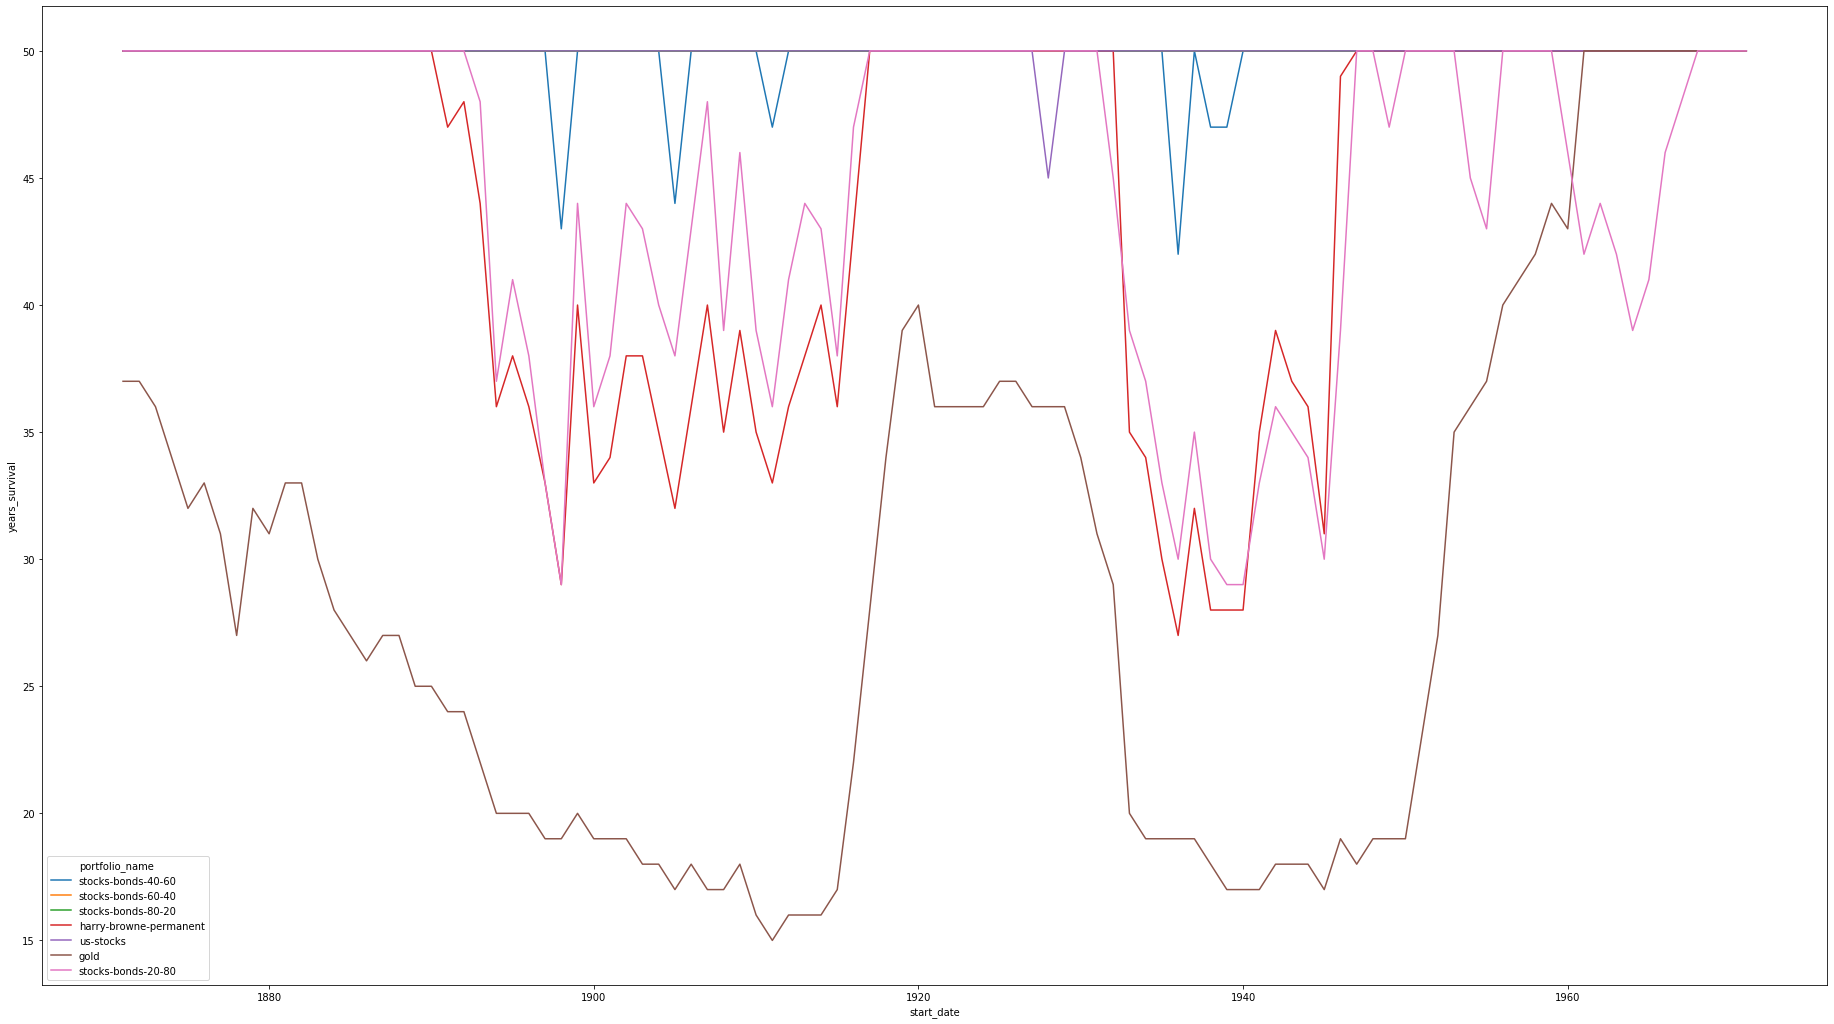

In [53]:
fig, ax = plt.subplots(figsize=(32,18))
sns.lineplot(x='start_date', y='years_survival', hue='portfolio_name', data=results_df[results_df['withdrawal_rate'] == 0.035]) 
plt.show()

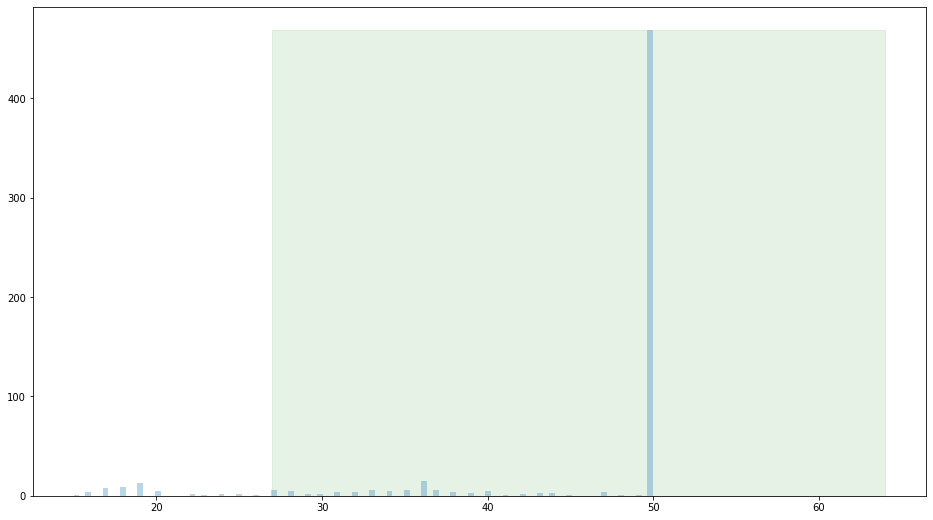

In [288]:
test_df = results_df
arr = test_df['years_survival']
plt.figure(figsize=(16,9))
ci = norm(*norm.fit(arr)).interval(0.95)  # fit a normal distribution and get 95% c.i.
height, bins, patches = plt.hist(arr, alpha=0.3, bins=100)
plt.fill_betweenx([0, height.max()], ci[0], ci[1], color='g', alpha=0.1)